In [30]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from pgmpy.estimators import K2Score, BicScore, BDeuScore
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, BayesianEstimator

# Define functions

## Scoring function

In [31]:
all_scores = pd.DataFrame(columns=['model', 'acc', 'auc', 'rec', 'prec', 'f-value', 'comment'])
all_scores.to_csv('./Data/model_all_scores.csv')

In [32]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, f1_score, recall_score, precision_score

def scoring_table(model, model_name, multi_class, comment):
  # model: model object e.g. of type SVC 
  # model_name: str of model name 
  # multi_class: ovr or ovo 
  # comment: model parameters
  
  # scoring parameters included are 
  # accuracy, auc (multi_class specified by user), recall, precision (both macro - unweighted mean),  
  
  global X_test
  global y_test

  all_scores = pd.read_csv('model_all_scores.csv', index_col=0)
  
  # if entry already present, this ifelse portion ensures that
  # we don't append duplicate entries to the csv 

  if model and comment in all_scores.values:
    return 
        
  else:

    # get predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_probability(X_test)

    # accuracy
    acc = round(accuracy_score(y_test,y_pred),4)

    # auc roc 
    auc = round(roc_auc_score(y_test,y_pred_proba, multi_class=multi_class),4)

    # recall
    rec = round(recall_score(y_test,y_pred, average='macro'),4)

    # precision
    prec = round(precision_score(y_test,y_pred, average='macro'),4)

    # f1
    f1 = round(f1_score(y_test,y_pred,  average='macro'),4)

    scores = pd.DataFrame([str(model_name), acc, auc, rec, prec, f1, str(comment)]).T
    scores.columns = all_scores.columns

    all_scores = pd.concat([all_scores,scores], axis=0, ignore_index=True)
    all_scores.to_csv('model_all_scores.csv')
    
    return all_scores

## Confusion matrix

In [33]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def c_matrix(model, title, filename):
  # model: model object
  # title: string title of confusion matrix
  # filename: string file name, please include .png at end
  
  global y_test
  y_pred = model.predict(X_test)
  
  f, ax = plt.subplots(figsize=(7, 5))
  sns.heatmap(confusion_matrix(y_test, y_pred),
              annot=True, 
              fmt="d", 
              linewidths=.5, 
              cmap="YlGnBu").set(title=str(title))
  
  plt.savefig(str(filename), dpi=400)


Feature selection of only most important features by RF

In [34]:
df = pd.read_csv('final_merged_normalized_discretized.csv', index_col=0)
df.drop(['CD', 'Year', 'Month'], axis=1, inplace=True)

In [35]:
df = df[['REFUSETONSCOLLECTED_pp', 'business_sqmi', 'MGPTONSCOLLECTED_pp', 
         'PAPERTONSCOLLECTED_pp', 'numbldgs', 'asland_sqft', 'unitstotal',
         'RESORGANICSTONS_pp', 'pop_density', 'fs_open_sqmi', 'dirty_level']] # subsetting most important features from rf

train,test=train_test_split(df,random_state=999,test_size=0.2) # split into holistic train and test sets for structure search

In [36]:
# hillclimbsearch to estimate structure 
from pgmpy.estimators import HillClimbSearch
hc = HillClimbSearch(train)
best_model = BayesianModel(hc.estimate(scoring_method=BicScore(train)).edges()) # convert DAG to BayesianModel
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('fs_open_sqmi', 'dirty_level'), ('dirty_level', 'pop_density')]


/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  FutureWarning,


In [37]:
best_model.fit(train, estimator=BayesianEstimator, prior_type='K2')

In [38]:
lt = list(best_model.edges()) # convert edges to list of sets 
out = [item for t in lt for item in t] # convert sets to list 

def unique(list1):
    x = np.array(list1)
    uniq = np.unique(x).tolist()
    return uniq

cols_to_keep = unique(out) # keep unique column names 

# split into X and y, keeping the columns involved in the bayes nets 
X_train = train[cols_to_keep].drop('dirty_level', axis=1)
y_train = train['dirty_level']

X_test = test[cols_to_keep].drop('dirty_level', axis=1)
y_test = test['dirty_level']

In [39]:
y_pred_train = best_model.predict(X_train)
y_pred = best_model.predict(X_test)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

In [40]:
model = best_model
y_pred = model.predict(X_test)
y_pred_proba = model.predict_probability(X_test)
roc_auc_score(y_test,y_pred_proba, multi_class='ovo')

  0%|          | 0/78 [00:00<?, ?it/s]

0.7695339248027512

In [41]:
scoring_table(best_model, 'bayes net subset', 'ovo', best_model.edges())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


  0%|          | 0/78 [00:00<?, ?it/s]

,model,acc,auc,rec,prec,f-value,comment
0,bayes net subset,0.5825,0.7695,0.5799,0.5716,0.5725,"[('fs_open_sqmi', 'dirty_level'), ('dirty_leve..."


  0%|          | 0/78 [00:00<?, ?it/s]

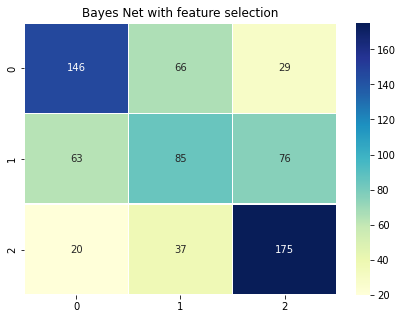

In [42]:
c_matrix(best_model, 'Bayes Net with feature selection', 'bn-featureselect.png')

No feature selection

In [43]:
df = pd.read_csv('final_merged_normalized_discretized.csv', index_col=0)
df.drop(['CD', 'Year', 'Month'], axis=1, inplace=True)

In [44]:
train,test=train_test_split(df,random_state=999,test_size=0.2) # split into holistic train and test sets for structure search

In [45]:
# hillclimbsearch to estimate structure 
hc = HillClimbSearch(train)
best_model = BayesianModel(hc.estimate(scoring_method=BicScore(train)).edges()) # convert DAG to BayesianModel
print(best_model.edges())

  0%|          | 0/1000000 [00:00<?, ?it/s]

[('wfr_avg_refuse', 'wfr_avg_bulk'), ('wfr_avg_refuse', 'wfr_avg_recycling'), ('wfr_avg_bulk', 'pct_bach_deg'), ('wfr_avg_bulk', 'pct_lot_area_open_space'), ('wfr_avg_bulk', 'pct_white_nh'), ('wfr_avg_bulk', 'wire_basket_sqmi'), ('wfr_avg_bulk', 'restaurant_sqmi'), ('wfr_avg_bulk', 'pct_lot_area_public_facility_institution'), ('wfr_avg_bulk', 'pct_lot_area_res_multifamily_walkup'), ('wfr_avg_bulk', 'total_litter_baskets_sqmi'), ('wfr_avg_bulk', 'pct_lot_area_res_1_2_family_bldg'), ('wfr_avg_bulk', 'pop_density'), ('wfr_avg_bulk', 'total_number_of_households'), ('wfr_avg_bulk', 'mgp_baskets_sqmi'), ('wfr_avg_bulk', 'paper_baskets_sqmi'), ('wfr_avg_bulk', 'unemployment'), ('wfr_avg_bulk', 'fs_openhours'), ('wfr_avg_bulk', 'fs_open_sqmi'), ('wfr_avg_bulk', 'hh_compost_percent'), ('wfr_avg_bulk', 'trs_permits'), ('unemployment', 'over65_rate'), ('unemployment', 'crime_per_1000'), ('unemployment', 'mean_commute'), ('unemployment', 'pct_clean_strts'), ('unemployment', 'pct_hh_rent_burd'), ('

/usr/local/lib/python3.7/dist-packages/pgmpy/models/BayesianModel.py:10: FutureWarning: BayesianModel has been renamed to BayesianNetwork. Please use BayesianNetwork class, BayesianModel will be removed in future.
  FutureWarning,


In [46]:
best_model.fit(train, estimator=BayesianEstimator, prior_type='K2')

In [47]:
lt = list(best_model.edges()) # convert edges to list of sets 
out = [item for t in lt for item in t] # convert sets to list 

cols_to_keep = unique(out) # keep unique column names 

# split into X and y, keeping the columns involved in the bayes nets 
X_train = train[cols_to_keep].drop('dirty_level', axis=1)
y_train = train['dirty_level']

X_test = test[cols_to_keep].drop('dirty_level', axis=1)
y_test = test['dirty_level']

In [48]:
scoring_table(best_model, 'bayes net full', 'ovo', best_model.edges())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


  0%|          | 0/94 [00:00<?, ?it/s]

,model,acc,auc,rec,prec,f-value,comment
0,bayes net subset,0.5825,0.7695,0.5799,0.5716,0.5725,"[('fs_open_sqmi', 'dirty_level'), ('dirty_leve..."
1,bayes net full,0.5696,0.755,0.5679,0.5696,0.5677,"[('wfr_avg_refuse', 'wfr_avg_bulk'), ('wfr_avg..."


  0%|          | 0/94 [00:00<?, ?it/s]

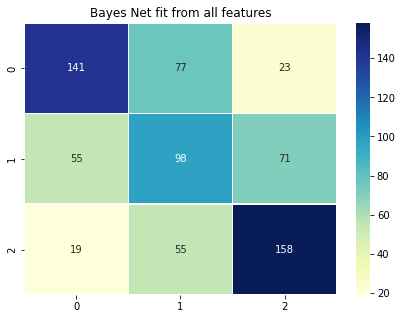

In [49]:
c_matrix(best_model, 'Bayes Net fit from all features', 'bn-allfeatures.png')